In [2]:
import os
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, MaxPool2D, Conv2D
from keras.applications.vgg19 import VGG19
from sklearn.model_selection import train_test_split
from keras.metrics import Recall,Precision,AUC
from sklearn.metrics import classification_report,confusion_matrix
from keras.models import save_model, load_model

In [33]:
data = []

for i in ["real_images_ela","fake_images_ela"]:

    if i=="real_images_ela":
        label = 'real'
    else:
        label = 'fake'

    data += [[f"{i}/{j}",label] for j in os.listdir(i)]

In [34]:
len(data)

6499

In [35]:
db = pd.DataFrame(data,columns=["path","label"])
db = db.sample(frac=1)
db.reset_index(inplace=True)
db.drop("index",axis=1,inplace=True)
db

,path,label
0,fake_images_ela/2377.png,fake
1,real_images_ela/1579.png,real
2,real_images_ela/1874.png,real
3,real_images_ela/2351.png,real
4,real_images_ela/2300.png,real
...,...,...
6494,fake_images_ela/1475.png,fake
6495,real_images_ela/1565.png,real
6496,fake_images_ela/2821.png,fake
6497,fake_images_ela/2002.png,fake


In [36]:
train_db, test_db = train_test_split(db, test_size=0.2, random_state=2, shuffle=True)
print(train_db.count())
print(test_db.count())

path     5199
label    5199
dtype: int64
path     1300
label    1300
dtype: int64


In [37]:
train_generator = ImageDataGenerator(validation_split=0.2)
test_generator = ImageDataGenerator()

train_imgs = train_generator.flow_from_dataframe(
    dataframe = train_db,
    x_col = "path",
    y_col = "label",
    target_size = (128, 128),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    subset = "training"
)

val_imgs = train_generator.flow_from_dataframe(
    dataframe = train_db,
    x_col = "path",
    y_col = "label",
    target_size = (128, 128),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    subset = "validation"
)

test_imgs = test_generator.flow_from_dataframe(
    dataframe = test_db,
    x_col = "path",
    y_col = "label",
    target_size = (128, 128),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = False
)

Found 4160 validated image filenames belonging to 2 classes.
Found 1039 validated image filenames belonging to 2 classes.
Found 1300 validated image filenames belonging to 2 classes.


In [38]:
base_model = VGG19(input_shape=(128, 128, 3), 
                         include_top=False,
                         weights="imagenet")

In [39]:
for layer in base_model.layers:
    layer.trainable=False

In [40]:
ela_model=Sequential()
ela_model.add(base_model)
ela_model.add(Dropout(0.5))
ela_model.add(Flatten())
ela_model.add(BatchNormalization())
ela_model.add(Dense(512,"relu",kernel_initializer="he_uniform"))
ela_model.add(BatchNormalization())
ela_model.add(Dense(2,activation='sigmoid'))

In [41]:
ela_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 512)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_4 (Bat  (None, 8192)              32768     
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 batch_normalization_5 (Bat  (None, 512)               2048      
 chNormalization)                                     

In [42]:
ela_model.compile(loss='binary_crossentropy',
              metrics=['accuracy',Precision(),Recall(),AUC()],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [43]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

callback_list = [earlystopping]

In [44]:
hist = ela_model.fit(train_imgs,
                    validation_data=val_imgs,
                    epochs = 10,
                    callbacks = callback_list)

Epoch 1/10
130/130 [==============================] - 180s 1s/step - loss: 0.0063 - accuracy: 0.9969 - precision_2: 0.9966 - recall_2: 0.9964 - auc_2: 1.0000 - val_loss: 1.1446e-05 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000 - val_auc_2: 1.0000
Epoch 2/10
130/130 [==============================] - 179s 1s/step - loss: 3.2565e-04 - accuracy: 1.0000 - precision_2: 0.9998 - recall_2: 1.0000 - auc_2: 1.0000 - val_loss: 4.8303e-05 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000 - val_auc_2: 1.0000
Epoch 3/10
130/130 [==============================] - 178s 1s/step - loss: 0.0024 - accuracy: 0.9995 - precision_2: 0.9990 - recall_2: 0.9995 - auc_2: 1.0000 - val_loss: 4.7906e-04 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000 - val_auc_2: 1.0000
Epoch 4/10
130/130 [==============================] - 184s 1s/step - loss: 6.2810e-05 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000 - val_loss: 0.0

In [45]:
save_model(ela_model,"ela_model.h5")

C:\Users\manav\AppData\Local\Temp\ipykernel_1300\1418637721.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(ela_model,"ela_model.h5")


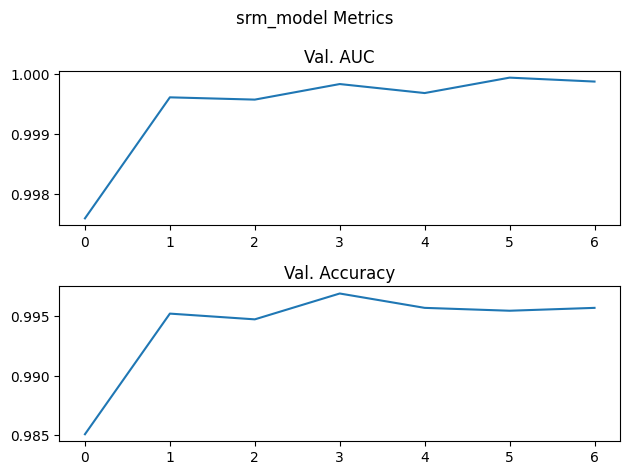

In [15]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(2,1)
ax[0].plot(hist.history["auc"])
ax[0].set_title("Val. AUC")

ax[1].plot(hist.history["accuracy"])
ax[1].set_title("Val. Accuracy")

fig.suptitle(f"srm_model Metrics")
fig.set_tight_layout(True)

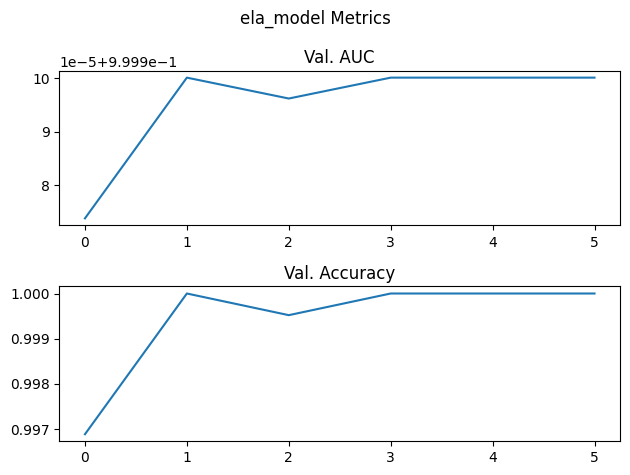

In [48]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(2,1)
ax[0].plot(hist.history["auc_2"])
ax[0].set_title("Val. AUC")

ax[1].plot(hist.history["accuracy"])
ax[1].set_title("Val. Accuracy")

fig.suptitle(f"ela_model Metrics")
fig.set_tight_layout(True)

In [17]:
y_pred = model.predict(test_imgs).argmax(axis=1)

41/41 [==============================] - 45s 1s/step


In [19]:
report = classification_report(test_imgs.labels,y_pred)
print("----------------------SRM Classifier ------------------------")
print(report)

----------------------SRM Classifier ------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       628
           1       1.00      1.00      1.00       672

    accuracy                           1.00      1300
   macro avg       1.00      1.00      1.00      1300
weighted avg       1.00      1.00      1.00      1300



In [46]:
y_pred_ela = ela_model.predict(test_imgs).argmax(axis=1)
ela_report = classification_report(test_imgs.labels,y_pred_ela)
print("----------------------ELA Classifier ------------------------")
print(ela_report)

41/41 [==============================] - 43s 1s/step
----------------------ELA Classifier ------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       647
           1       1.00      1.00      1.00       653

    accuracy                           1.00      1300
   macro avg       1.00      1.00      1.00      1300
weighted avg       1.00      1.00      1.00      1300

